Data preparation completed in 0.02 seconds.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/100], Loss: 41.8163
Epoch [20/100], Loss: 35.2307
Epoch [30/100], Loss: 29.2540
Epoch [40/100], Loss: 24.5032
Epoch [50/100], Loss: 20.4588
Epoch [60/100], Loss: 17.4600
Epoch [70/100], Loss: 15.3641
Epoch [80/100], Loss: 13.0802
Epoch [90/100], Loss: 10.1651
Epoch [100/100], Loss: 8.2082
Training completed in 2.16 seconds.
Test MSE: 123.3410
Evaluation completed in 0.00 seconds.


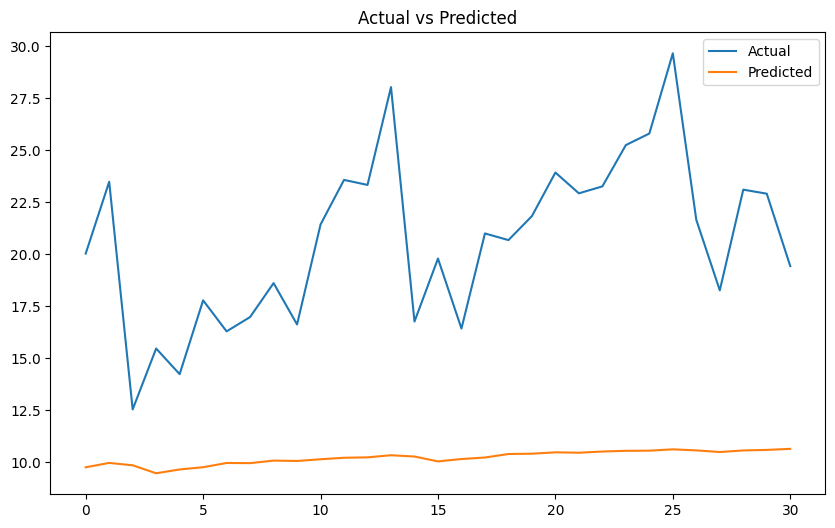

In [19]:
import time
import numpy as np
import pandas as pd
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- Data Preparation ---

def load_wfm_data(seq_length: int) -> tuple:
    url = 'https://raw.githubusercontent.com/selva86/datasets/master/a10.csv'
    df = pd.read_csv(url)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')

    values = df['value'].values  # This represents workforce demand (e.g., drug sales time series, close to WFM structure)

    X, y = [], []
    for i in range(len(values) - seq_length):
        X.append(values[i:i+seq_length])
        y.append(values[i+seq_length])

    return np.array(X), np.array(y)

start_time = time.time()

SEQ_LENGTH = 50
X, y = load_wfm_data(SEQ_LENGTH)

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Data preparation completed in {time.time() - start_time:.2f} seconds.")

# --- Model Definition ---

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim: int, d_model: int, nhead: int, num_layers: int, output_dim: int):
        super(TimeSeriesTransformer, self).__init__()
        self.input_linear = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_linear = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = self.input_linear(x)
        x = x.unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.output_linear(x)
        return x

# --- Training ---

def train_model(model, criterion, optimizer, X_train, y_train, epochs: int = 100):
    losses = []
    model.train()
    for epoch in range(epochs):
        inputs = torch.tensor(X_train, dtype=torch.float32)
        targets = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    return losses

start_time = time.time()

INPUT_DIM = SEQ_LENGTH
D_MODEL = 64
NHEAD = 4
NUM_LAYERS = 2
OUTPUT_DIM = 1
EPOCHS = 100

model = TimeSeriesTransformer(INPUT_DIM, D_MODEL, NHEAD, NUM_LAYERS, OUTPUT_DIM)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = train_model(model, criterion, optimizer, X_train, y_train, epochs=EPOCHS)

print(f"Training completed in {time.time() - start_time:.2f} seconds.")

# --- Evaluation ---

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X_test, dtype=torch.float32)
        targets = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
        predictions = model(inputs)
        mse = nn.MSELoss()(predictions, targets)
        print(f"Test MSE: {mse.item():.4f}")
    return predictions.squeeze().numpy(), targets.squeeze().numpy()

start_time = time.time()

predictions, actuals = evaluate_model(model, X_test, y_test)

print(f"Evaluation completed in {time.time() - start_time:.2f} seconds.")

# --- Plot Results ---

def plot_predictions(actuals, predictions):
    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title("Actual vs Predicted")
    plt.legend()
    plt.show()

plot_predictions(actuals, predictions)